In [1]:
import pandas
import datetime
import feather
import numpy
import scipy.optimize
from aacgmv2 import convert_mlt
import seaborn as sns
from davitpy import utils
from imagers.ssusi import ssusi_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
# Some constants
eventDate = datetime.datetime(2011,7,5)
timeStart = datetime.datetime(2011,7,5,3,0)
timeEnd = datetime.datetime(2011,7,5,6,0)
sapsTime = datetime.datetime(2011,7,5,5,2)
sapsTimeRange = [ datetime.datetime(2011,7,5,3,0),\
              datetime.datetime(2011,7,5,6,0) ]
sapsMlatRange = [ 52., 63. ]#[ 56., 60. ]
velMagnScale = [ 0, 1200 ]
coords="mlt"
# TEC variables
tecScale = [ 0, 10 ]
trghLatRange = [ 50, 70 ]
trghMlatRange = [ 50, 65 ]
# discard the edge MLTs
# these are the MLTs we'll plot
# pltNormMltList = [ -4, -3, -2, -1, 0 ]
# AMPERE vars
ampSCWTimeRange = [ datetime.datetime(2011,7,5,3,30),\
              datetime.datetime(2011,7,5,7,0) ]

In [3]:
def round2(number):
    """
    Round a number to the closest half integer.
    """
    return round(number * 2) / 2

def get_west_vel(row):
    westVel = row['vLos']/( numpy.cos(\
                 numpy.deg2rad( 90.-\
                    row['azimCalcMag'] ) ) )
    if westVel >= 2000.:
        return numpy.nan
    return westVel


def convert_to_datetime(row):
    currDateStr = str( int( row["dateStr"] ) )
#     return currDateStr
    if row["timeStr"] < 10:
        currTimeStr = "000" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 100:
        currTimeStr = "00" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 1000:
        currTimeStr = "0" + str( int( row["timeStr"] ) )
    else:
        currTimeStr = str( int( row["timeStr"] ) )
    return datetime.datetime.strptime( currDateStr\
                    + ":" + currTimeStr, "%Y%m%d:%H%M" )


def get_mlon_from_mlt(row):
    if row["normMlt"] < 0: 
        currMLT = row["normMlt"] + 24.
    else:
        currMLT = row["normMlt"]
    if row["endPtnormMlt"] < 0: 
        currEndptMLT = row["endPtnormMlt"] + 24.
    else:
        currEndptMLT = row["endPtnormMlt"]
    row["Mlon"] = numpy.round( \
                        convert_mlt( currMLT, row["date"] , m2a=True ) )
    if row["Mlon"] > 180.:
        row["Mlon"] -= 360.
    row["EndptMlon"] = numpy.round( \
                        convert_mlt( currEndptMLT, row["date"] , m2a=True ) )
    if row["EndptMlon"] > 180.:
        row["EndptMlon"] -= 360.
    return row

def format_mlt_normMLT_ticks(tick_val, tick_pos):
    if tick_val < 0:
        return str(tick_val + 24)
    else:
        return str(tick_val)

In [4]:
# read from sd L-shell Vecs from the feather file
lshellDF = feather.read_dataframe('../data/lshellFits-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
lshellDF = lshellDF[ (lshellDF["velSAPS"] > 0.) &\
                    (lshellDF["velSAPS"] < 2000.) ].reset_index(drop=True)
lshellDF = lshellDF[ lshellDF["mlat"] <= 61]
lshellDF["endPtmlat"] = numpy.round( (lshellDF["velSAPS"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*lshellDF["azimSAPS"]) ) +\
                                lshellDF["mlat"], 2)
lshellDF["endPtnormMlt"] = numpy.round( (lshellDF["velSAPS"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*lshellDF["azimSAPS"]) ) +\
                                lshellDF["normMlt"], 2)
lshellDF = lshellDF[ lshellDF["normMlt"] > -6 ].reset_index(drop=True)
lshellDF = lshellDF.apply( get_mlon_from_mlt, axis=1 )
lshellDF.head()

,azimSAPS,azimSTD,delMLT,goodFit,mlat,normMlt,velSAPS,velSTD,endPtMLAT,endPtNormMLT,date,endPtmlat,endPtnormMlt,Mlon,EndptMlon
0,15.083845,6.610516,1.5,True,59.0,-2.0,349.126369,33.397030,58.91,-2.34,2011-07-05 04:00:00,58.91,-2.34,-17.0,-22.0
1,15.704863,2.943747,1.5,True,59.0,-3.0,345.693567,19.495890,58.91,-3.33,2011-07-05 04:00:00,58.91,-3.33,-32.0,-37.0
2,4.222649,3.620818,1.5,True,59.5,-2.0,303.585017,29.043018,59.48,-2.30,2011-07-05 04:00:00,59.48,-2.30,-17.0,-22.0
3,19.073163,1.517291,1.5,True,58.5,-4.0,391.855314,28.287167,58.37,-4.37,2011-07-05 04:00:00,58.37,-4.37,-47.0,-53.0
4,15.200143,1.697521,1.5,True,59.0,-4.0,355.620902,23.967516,58.91,-4.34,2011-07-05 04:00:00,58.91,-4.34,-47.0,-52.0


In [5]:
ampSCWDF = feather.read_dataframe('../data/amp-scw-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
ampSCWDF["scwNormMLTDown"] = [ x-24 if x>12 else x for x in ampSCWDF["scwMLTDown"] ]
ampSCWDF["scwNormMLTUp"] = [ x-24 if x>12 else x for x in ampSCWDF["scwMLTUp"] ]
ampSCWDF = ampSCWDF[ (ampSCWDF["scwLocDates"] >= ampSCWTimeRange[0]) &\
                   (ampSCWDF["scwLocDates"] <= ampSCWTimeRange[1]) ]
ampSCWDF.head()

,scwJrDown,scwJrUp,scwLocDates,scwLocMlatDown,scwLocMlatUp,scwMLTDown,scwMLTUp,scwNormMLTDown,scwNormMLTUp
64,-0.21,0.05,2011-07-05 03:30:00,57.0,60.0,19.0,19.0,-5.0,-5.0
65,-0.12,0.09,2011-07-05 03:30:00,56.0,60.0,20.0,20.0,-4.0,-4.0
66,-0.11,0.14,2011-07-05 03:30:00,56.0,58.0,22.0,22.0,-2.0,-2.0
67,-0.09,0.22,2011-07-05 03:30:00,56.0,59.0,23.0,23.0,-1.0,-1.0
68,-0.05,0.28,2011-07-05 03:30:00,56.0,59.0,1.0,1.0,1.0,1.0


In [6]:
# read TEC data from the feather file
tecDF = feather.read_dataframe('../data/tec-mf-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
tecDF["mltRound"] = numpy.round( tecDF["MLT"] ) % 24
tecDF.head()

,dateStr,timeStr,Mlat,Mlon,med_tec,dlat,dlon,date,MLT,mltRound
0,20110705,300,11.0,0.0,5.4,1.0,2.0,2011-07-05 03:00:00,22.205744,22.0
1,20110705,300,11.0,2.0,10.2,1.0,2.0,2011-07-05 03:00:00,22.339078,22.0
2,20110705,300,11.0,4.0,8.9,1.0,2.0,2011-07-05 03:00:00,22.472411,22.0
3,20110705,300,11.0,6.0,7.5,1.0,2.0,2011-07-05 03:00:00,22.605744,23.0
4,20110705,300,11.0,8.0,7.4,1.0,2.0,2011-07-05 03:00:00,22.739078,23.0


In [7]:
# get a timeseries plot of the vectors
# for a given time, get max vectors at each MLT
selCols = [ 'normMlt', 'velSAPS', 'azimSAPS', 'date' ]
meanVelMltDF = lshellDF[selCols].groupby(\
            [ 'normMlt', 'date' ] \
            ).mean().reset_index()
meanVelMltDF["time"] = [ date2num(x) for x in meanVelMltDF["date"] ]
meanVelMltDF["endPtTime"] = (meanVelMltDF["velSAPS"]/2e5) *\
                                numpy.cos( numpy.deg2rad(\
                                -90-1*meanVelMltDF["azimSAPS"]) ) +\
                                meanVelMltDF["time"]
meanVelMltDF["endPtnormMlt"] = numpy.round( (meanVelMltDF["velSAPS"]/2000.) *\
                                numpy.sin( numpy.deg2rad(\
                                -90-1*meanVelMltDF["azimSAPS"]) ) +\
                                meanVelMltDF["normMlt"], 2 )
meanVelMltDF = meanVelMltDF[ ( meanVelMltDF["date"] >= sapsTimeRange[0] ) &\
               ( meanVelMltDF["date"] <= sapsTimeRange[1] )\
               ].reset_index(drop=True)
meanVelMltDF = meanVelMltDF[ meanVelMltDF["normMlt"] > -6 ].reset_index(drop=True)

meanVelMltDF.head()

,normMlt,date,velSAPS,azimSAPS,time,endPtTime,endPtnormMlt
0,-5.0,2011-07-05 04:12:00,320.493992,-5.561110,734323.175000,734323.175155,-5.16
1,-5.0,2011-07-05 04:14:00,329.223149,-8.507512,734323.176389,734323.176632,-5.16
2,-5.0,2011-07-05 04:16:00,384.619574,-13.667435,734323.177778,734323.178232,-5.19
3,-5.0,2011-07-05 04:22:00,1030.515186,-13.630760,734323.181944,734323.183159,-5.50
4,-5.0,2011-07-05 04:24:00,760.179121,-14.569777,734323.183333,734323.184289,-5.37


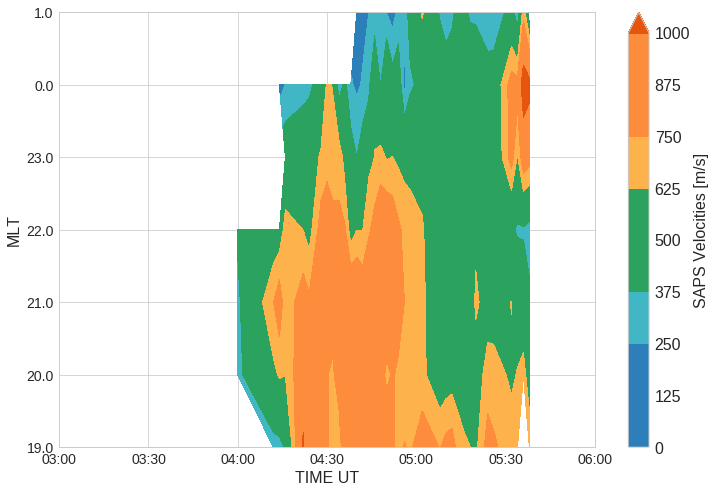

In [8]:
# setup data
plotMLTends = meanVelMltDF['endPtnormMlt'].tolist()#meanVelMltDF['endPtMlon'].tolist()#
plotmlatends = meanVelMltDF['endPtTime'].tolist()
plotMLTbegins = meanVelMltDF['normMlt'].tolist()#meanVelMltDF['Mlon'].tolist()#
plotmlatbegins = meanVelMltDF['time'].tolist()
plotVelMagns = meanVelMltDF['velSAPS'].tolist()
# Seaborn styling# OrRd
sns.set_style("whitegrid")
sns.set_context("paper")
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
# set colorbar
colors = [ "#2c7fb8", "#41b6c4", "#2ca25f", "#feb24c", "#fd8d3c", "#e6550d" ]
seaMap = ListedColormap(sns.color_palette(colors))
# set a few standard xticks
yTickList = []
currTime = sapsTimeRange[0]
while currTime <= sapsTimeRange[1]:
    yTickList.append( currTime )
    currTime += datetime.timedelta(minutes=15)
    
    
# lshellPlot = ax.scatter( x=meanVelMltDF["time"], y=meanVelMltDF["normMlt"],\
#                      c=meanVelMltDF["velSAPS"],cmap=seaMap,\
#                      vmin=velMagnScale[0],vmax=velMagnScale[1], s=1 )

plotDF = meanVelMltDF[ ["time", "normMlt",\
                        "velSAPS"] ].pivot( "time", "normMlt" )

timeVals = plotDF.index.values
nMltVals = plotDF.columns.levels[1].values


timeCntr, nMltCntr  = numpy.meshgrid( timeVals, nMltVals )
# Mask the nan values! pcolormesh can't handle them well!
vMagnVals = numpy.ma.masked_where(numpy.isnan(plotDF["velSAPS"].values),\
                                  plotDF["velSAPS"].values)

# rtiPlot = ax.pcolormesh(timeCntr.T, nMltCntr.T , vMagnVals,\
#                         cmap=seaMap, vmin=velMagnScale[0],vmax=velMagnScale[1])

rtiPlot = ax.contourf(timeCntr.T, nMltCntr.T , vMagnVals,\
                        cmap=seaMap, levels=numpy.linspace(0, 1000, 9), extend='max',\
                      vmin=velMagnScale[0],\
                      vmax=velMagnScale[1])
ax.set_xlim( sapsTimeRange )
# ax.set_xlim( [ -80, 0 ] )
ax.set_xlabel("TIME UT", fontsize=16)
ax.set_ylabel("MLT", fontsize=16)
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.yaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))
        
cb = plt.colorbar(rtiPlot, ax=ax, cmap=seaMap)
cb.ax.tick_params(labelsize=16)
cb.ax.set_ylabel('SAPS Velocities [m/s]', fontsize=16)


# f.savefig("../plots/lshell-mean-timseries-" +\
#             sapsTime.strftime("%Y%m%d") +\
#             ".pdf" ,bbox_inches='tight')

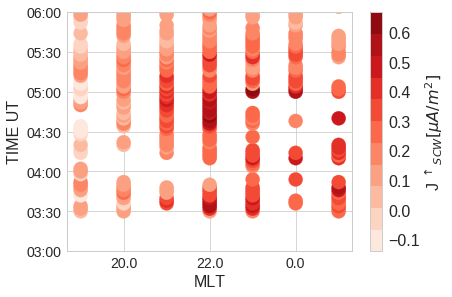

In [9]:
sns.set_style("whitegrid")
sns.set_context("paper")
colList = [ "firebrick", "seagreen", "#2c7fb8" ]
seaMap = ListedColormap(sns.color_palette("Reds",11))

fig = plt.figure()
ax = fig.add_subplot(111)

ampSCWPlot = ax.scatter( x=ampSCWDF["scwNormMLTUp"].values,\
                        y=ampSCWDF["scwLocDates"].values,\
                        c=ampSCWDF["scwJrUp"].values, cmap=seaMap,s=200 )

ax.set_ylim( sapsTimeRange )
ax.set_ylabel("TIME UT", fontsize=16)
ax.set_xlabel("MLT", fontsize=16)
ax.get_yaxis().set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))
        
cb = plt.colorbar(ampSCWPlot, ax=ax, cmap=seaMap)
cb.ax.tick_params(labelsize=16)
cb.ax.set_ylabel(r"J $^{\uparrow}$$_{SCW} [\mu A/m^{2}]$", fontsize=16)

In [10]:
# Get the min loc of trough at diff MLONs
trghLocsDF = tecDF[ (tecDF["med_tec"] <= 20.) &\
                  (tecDF["Mlat"] >= trghLatRange[0]) &\
                  (tecDF["Mlat"] <= trghLatRange[1]) ]
trghLocsDF["time"] = [ date2num(x) for x in trghLocsDF["date"] ]
trghMinDF = trghLocsDF[ ["time", "Mlon", "med_tec"]\
                 ].groupby( [ "time", "Mlon" ]\
                ).mean().reset_index()
trghMinDF["Mlon2"] = [x-360 if x>180 else x for x in trghMinDF["Mlon"] ]
trghMinDF.head()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,time,Mlon,med_tec,Mlon2
0,734323.125,0.0,8.911111,0.0
1,734323.125,2.0,8.841176,2.0
2,734323.125,4.0,8.388235,4.0
3,734323.125,6.0,8.305882,6.0
4,734323.125,8.0,8.115789,8.0


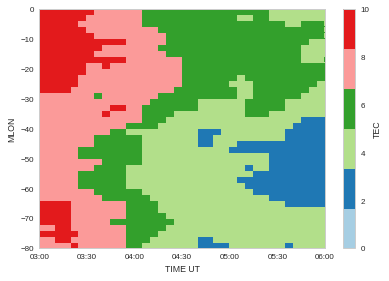

In [11]:
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Paired"))
# xticks
# set a few standard xticks
xTickList = []
currTime = timeStart
while currTime <= timeEnd:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=30)
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
plotDF = trghMinDF[ ["time", "Mlon2",\
                        "med_tec"] ].pivot( "time", "Mlon2" )

timeVals = plotDF.index.values
mlonVals = plotDF.columns.levels[1].values

timeCntr, mlonCntr  = numpy.meshgrid( timeVals, mlonVals )
# Mask the nan values! pcolormesh can't handle them well!
tecVals = numpy.ma.masked_where(\
                numpy.isnan(plotDF["med_tec"].values),\
                plotDF["med_tec"].values)
rtiPlot = ax.pcolormesh(timeCntr.T, mlonCntr.T , tecVals,\
                        cmap=seaMap, vmin=tecScale[0],vmax=tecScale[1])

ax.set_xlim( [ timeStart, timeEnd ] )
ax.set_ylim( [ -80, 0 ] )
ax.set_xlabel("TIME UT")
ax.set_ylabel("MLON")
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

ax.set_xticks(xTickList)

cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("TEC")


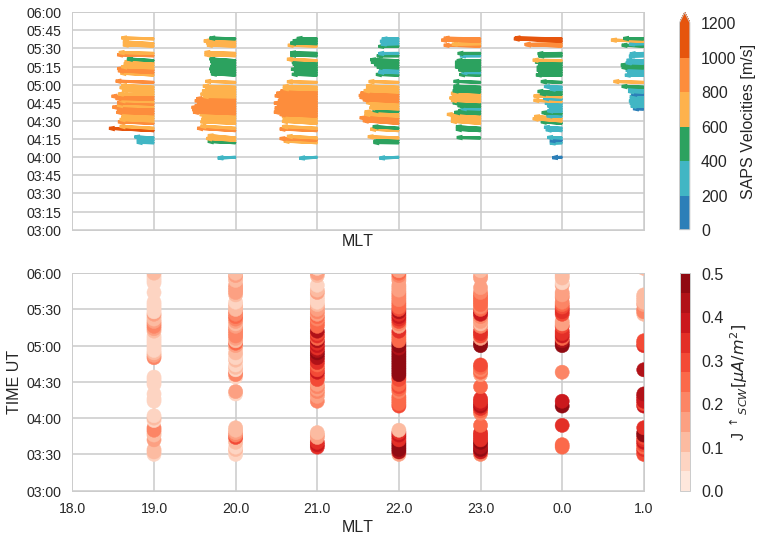

In [12]:
# Setup Fig
sns.set_style("whitegrid")
sns.set_context("poster")
f = plt.figure(figsize=(12, 8))
f, axArr = plt.subplots(2, sharex=True)

# First plot Lshell Vecs
# First plot Lshell Vecs
plotMLTends = meanVelMltDF['endPtnormMlt'].tolist()#meanVelMltDF['endPtMlon'].tolist()#
plotmlatends = meanVelMltDF['endPtTime'].tolist()
plotMLTbegins = meanVelMltDF['normMlt'].tolist()#meanVelMltDF['Mlon'].tolist()#
plotmlatbegins = meanVelMltDF['time'].tolist()
plotVelMagns = meanVelMltDF['velSAPS'].tolist()
# set colorbar
colors = [ "#2c7fb8", "#41b6c4", "#2ca25f", "#feb24c", "#fd8d3c", "#e6550d" ]
seaMap = ListedColormap(sns.color_palette(colors))
# set a few standard xticks
yTickList = []
currTime = sapsTimeRange[0]
while currTime <= sapsTimeRange[1]:
    yTickList.append( currTime )
    currTime += datetime.timedelta(minutes=15)
    
lshellPlot = axArr[0].scatter( x=meanVelMltDF["normMlt"], y=meanVelMltDF["time"],\
                     c=meanVelMltDF["velSAPS"], cmap=seaMap,\
                     vmin=velMagnScale[0],vmax=velMagnScale[1], s=1 )

colNorm = Normalize( vmin=velMagnScale[0], vmax=velMagnScale[1] )
for currMLTend, currmlatend, currMLTbgn, currmlatbgn, currVel in\
        zip( plotMLTends, plotmlatends, plotMLTbegins, plotmlatbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
#         print currMLTbgn, currMLTend
#         print currmlatbgn, currmlatend
#         axArr[0].plot( [currMLTbgn, currMLTend], [ currmlatbgn, currmlatend ], color=currCol )   
#         axArr[0].scatter( currMLTend, currmlatend , s=10, color=currCol, marker="<" )  
#         axArr[0].arrow( currMLTbgn, currmlatbgn, currMLTend-currMLTbgn, currmlatend-currmlatbgn,\
#                  head_width=0.0015, head_length=0.075, fc=currCol, ec=currCol, ls='--')
        axArr[0].arrow( currMLTbgn, currmlatbgn, currMLTend-currMLTbgn,\
                 currmlatend-currmlatbgn, head_width=0.001,\
                 head_length=0.05, fc=currCol,width=0.0001,\
                 ec=currCol, lw='3')
        
axArr[0].set_xlim( [-6,1] )
axArr[0].set_yticks(yTickList)
axArr[0].get_yaxis().set_major_formatter(DateFormatter('%H:%M'))
axArr[0].xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))
axArr[0].yaxis.set_tick_params(labelsize=14)
axArr[0].xaxis.set_tick_params(labelsize=14)
axArr[0].set_xlabel('MLT', fontsize=16)
# axArr[0].set_ylabel('UT TIME', fontsize=16)

cb = plt.colorbar(lshellPlot, ax=axArr[0], cmap=seaMap, extend='max')
cb.ax.tick_params(labelsize=16)
cb.ax.set_ylabel('SAPS Velocities [m/s]', fontsize=16)
# First plot Lshell Vecs
# First plot Lshell Vecs

# Second plot AMPERE SCW
# Second plot AMPERE SCW
seaMap = ListedColormap(sns.color_palette("Reds",11))

ampSCWPlot = axArr[1].scatter( x=ampSCWDF["scwNormMLTUp"].values, y=ampSCWDF["scwLocDates"].values,\
          c=numpy.abs(ampSCWDF["scwJrUp"].values), cmap=seaMap,s=200, vmin=0., vmax=0.5 )

axArr[1].set_ylim( sapsTimeRange )
axArr[1].set_ylabel("TIME UT", fontsize=16)
axArr[1].set_xlabel("MLT", fontsize=16)
axArr[1].get_yaxis().set_major_formatter(DateFormatter('%H:%M'))
axArr[1].yaxis.set_tick_params(labelsize=14)
axArr[1].xaxis.set_tick_params(labelsize=14)
axArr[1].xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))
        
cb = plt.colorbar(ampSCWPlot, ax=axArr[1], cmap=seaMap)
cb.ax.tick_params(labelsize=16)
cb.ax.set_ylabel(r"J $^{\uparrow}$$_{SCW} [\mu A/m^{2}]$", fontsize=16)

# Second plot AMPERE SCW
# Second plot AMPERE SCW

f.savefig("../plots/vels-tec-amp-ts-" +\
            sapsTime.strftime("%Y%m%d") +\
            ".pdf" ,bbox_inches='tight')

In [13]:
tecMLTMeanDF = tecDF[ ["date", "Mlat", "Mlon",\
            "MLT", "mltRound", "med_tec"]\
            ].groupby( [ "date", "mltRound", "Mlat"] \
            ).mean().reset_index()
tecMLTStdDF = tecDF[ ["date", "Mlat", "Mlon",\
            "MLT", "mltRound", "med_tec"]\
            ].groupby( [ "date", "mltRound", "Mlat"] \
            ).std().reset_index()
tecMLTStdDF.columns = [ "date", "mltRound", "Mlat",\
                       "Mlon_std", "MLT_std", "med_tec_std" ]
tecMLTMeanDF = pandas.merge( tecMLTMeanDF,\
                tecMLTStdDF, on=[ "date", "mltRound", "Mlat"] )
tecMLTMeanDF.head()

,date,mltRound,Mlat,Mlon,MLT,med_tec,Mlon_std,MLT_std,med_tec_std
0,2011-07-05 03:00:00,0.0,11.0,27.0,12.005744,4.7125,4.898979,12.544473,1.464277
1,2011-07-05 03:00:00,0.0,12.0,27.0,12.005744,4.7500,4.898979,12.544473,1.482276
2,2011-07-05 03:00:00,0.0,13.0,27.0,12.005744,4.9375,4.898979,12.544473,1.616820
3,2011-07-05 03:00:00,0.0,14.0,23.0,23.739078,7.8250,2.581989,0.172133,0.450000
4,2011-07-05 03:00:00,0.0,15.0,22.0,23.672411,7.9000,2.000000,0.133333,0.519615


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


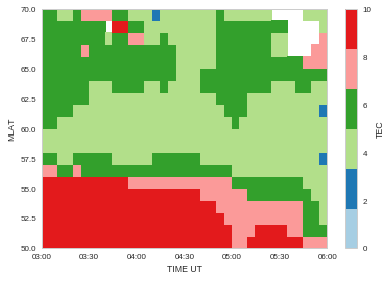

In [14]:
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
# setup the figure
fig = plt.figure()
ax = fig.add_subplot(111)
seaMap = ListedColormap(sns.color_palette("Paired"))
pltTECMlt = 23
# xticks
# set a few standard xticks
xTickList = []
currTime = timeStart
while currTime <= timeEnd:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=30)
    
selDF = tecMLTMeanDF[ ((tecMLTMeanDF["date"] >= timeStart) &\
                       (tecMLTMeanDF["date"] <= timeEnd) &\
                    (tecMLTMeanDF["Mlat"] <= trghLatRange[1]) &\
                       (tecMLTMeanDF["Mlat"] >= trghLatRange[0]) &\
                      (tecMLTMeanDF["mltRound"] == pltTECMlt))]
selDF["time"] = [ date2num(x) for x in selDF["date"] ]
selDF = selDF[ ["Mlat", "time", "med_tec"]\
             ].groupby( ["Mlat", "time"] ).median().reset_index()

plotmedFiltTECDF = selDF[ ["Mlat", "time",\
                        "med_tec"] ].pivot( "Mlat", "time" )
mlatVals = plotmedFiltTECDF.index.values
timeVals = plotmedFiltTECDF.columns.levels[1].values
mlatCntr, timeCntr  = numpy.meshgrid( mlatVals, timeVals )
med_tecVals = numpy.ma.masked_where(numpy.isnan(plotmedFiltTECDF["med_tec"].values),plotmedFiltTECDF["med_tec"].values)
trghPlot = ax.pcolormesh(timeCntr, mlatCntr,med_tecVals.T,\
                         cmap=seaMap, vmin=tecScale[0], vmax=tecScale[1])
ax.set_xlim( [ timeStart, timeEnd ] )
ax.set_xlabel("TIME UT")
ax.set_ylabel("MLAT")
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))


cbar = plt.colorbar(trghPlot, orientation='vertical')
cbar.set_label("TEC")

In [15]:
trghTECMeanDF = tecMLTMeanDF[ (tecMLTMeanDF["Mlat"] >= trghMlatRange[0]) &\
                            (tecMLTMeanDF["Mlat"] <= trghMlatRange[1]) ]
trghTECMeanDF = trghTECMeanDF.groupby( ["date", "mltRound"] ).median().reset_index()
trghTECMeanDF["normMlt"] = [ x-24 if x > 12 else x for x in trghTECMeanDF["mltRound"] ]
trghTECMeanDF.head()#["mltRound"].unique()

,date,mltRound,Mlat,Mlon,MLT,med_tec,Mlon_std,MLT_std,med_tec_std,normMlt
0,2011-07-05 03:00:00,0.0,57.5,26.571429,13.672411,6.029167,5.126960,12.532725,0.792016,0.0
1,2011-07-05 03:00:00,1.0,57.5,41.833333,0.994633,5.925000,4.320494,0.288033,0.983870,1.0
2,2011-07-05 03:00:00,2.0,60.5,57.000000,2.005744,3.193750,4.898979,0.326599,1.565481,2.0
3,2011-07-05 03:00:00,3.0,58.0,72.000000,3.005744,3.371429,3.741657,0.249444,0.357771,3.0
4,2011-07-05 03:00:00,4.0,57.5,87.000000,4.005744,3.912500,4.898979,0.326599,0.473142,4.0


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


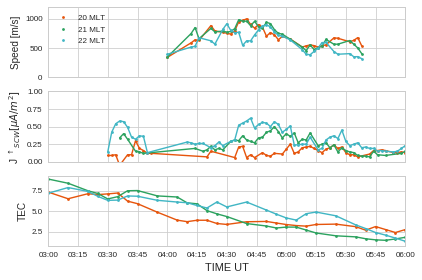

In [16]:
sns.set_style("whitegrid")
sns.set_context("paper")
# Select MLTs to plot
plotMlts = [ 20, 21, 22 ]# set colorbar
# colors = [ "#e6550d", "#fd8d3c", "#feb24c", "#2ca25f", "#41b6c4", "#2c7fb8" ]
colors = [ "#e6550d", "#2ca25f", "#41b6c4", "#2c7fb8" ]
# set a few standard xticks
xTickList = []
currTime = sapsTimeRange[0]
while currTime <= sapsTimeRange[1]:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=15)
# Plot the data
fig = plt.figure()
f, axArr = plt.subplots(3, sharex=True)

for nm, mm in enumerate(plotMlts):
    if mm < 12:
        cnMlt = mm
    else:
        cnMlt = mm - 24
    selDF = meanVelMltDF[ meanVelMltDF["normMlt"] == cnMlt ]
    axArr[0].plot_date( selDF["date"].values,\
                selDF["velSAPS"].values, '-', c=colors[nm] )
    axArr[0].plot_date( selDF["date"].values,\
                selDF["velSAPS"].values, '.', c=colors[nm], label=str(mm) + " MLT" )
    selAmpDF = ampSCWDF[ ampSCWDF["scwNormMLTUp"] == cnMlt ]
    axArr[1].plot_date( selAmpDF["scwLocDates"].values,\
                selAmpDF["scwJrUp"].values, '-', c=colors[nm] )
    axArr[1].plot_date( selAmpDF["scwLocDates"].values,\
                selAmpDF["scwJrUp"].values, '.', c=colors[nm] )
    selTECDF = trghTECMeanDF[ trghTECMeanDF["mltRound"] == mm ]
    axArr[2].plot_date( selTECDF["date"].values,\
                selTECDF["med_tec"].values, '-', c=colors[nm] )
    axArr[2].plot_date( selTECDF["date"].values,\
                selTECDF["med_tec"].values, '.', c=colors[nm] )
# sns.pointplot(x="date", y="velSAPS", hue="normMlt",data=meanVelMltDF,ax=ax, palette="Set2")


axArr[0].set_ylabel("Speed [m/s]", fontsize=10)
axArr[0].set_xlim( sapsTimeRange )
axArr[0].set_ylim( [0,1200] )
axArr[0].set_xticks(xTickList)
axArr[0].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
axArr[0].legend()

axArr[1].set_ylabel(r"J $^{\uparrow}$$_{SCW} [\mu A/m^{2}]$", fontsize=10)
axArr[1].set_xlim( sapsTimeRange )
axArr[1].set_ylim( [0,1.] )
axArr[1].set_xticks(xTickList)
axArr[1].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
axArr[1].legend()

axArr[2].set_ylabel("TEC", fontsize=10)
axArr[2].set_xlim( sapsTimeRange )
axArr[2].set_xticks(xTickList)
axArr[2].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
axArr[2].legend()

axArr[-1].set_xlabel("TIME UT", fontsize=11)

f.savefig("../plots/vels-scw-tec-" +\
            sapsTime.strftime("%Y%m%d") +\
            ".pdf" ,bbox_inches='tight')

In [17]:
# get a timeseries plot of the vectors
# for a given time, get mean vecs across
# all MLT values.
selCols = [ 'velSAPS', 'azimSAPS', 'date' ]
meanVelDF = lshellDF[selCols].groupby(\
            [ 'date' ] \
            ).mean().reset_index()
stdVelDF = lshellDF[selCols].groupby(\
            [ 'date' ] \
            ).mean().reset_index()
stdVelDF.columns = [ 'date', 'velSAPS_std', 'azimSAPS_std' ]
meanVelDF = pandas.merge( meanVelDF, stdVelDF, on=['date'] )
# meanVelDF["time"] = [ date2num(x) for x in meanVelDF["date"] ]
meanVelDF = meanVelDF[ ( meanVelDF["date"] >= sapsTimeRange[0] ) &\
               ( meanVelDF["date"] <= sapsTimeRange[1] )\
               ].reset_index(drop=True)

meanVelDF.head()
# Get Mean SCW across all MLTs
selCols = [ "scwJrDown", "scwJrUp", "scwLocDates" ]
meanAmpScwDF = ampSCWDF[selCols].groupby(\
            [ 'scwLocDates' ] \
            ).mean().reset_index()
stdAmpScwDF = ampSCWDF[selCols].groupby(\
            [ 'scwLocDates' ] \
            ).std().reset_index()
stdAmpScwDF.columns = [ 'scwLocDates', 'scwJrDown_std', 'scwJrUp_std' ]
meanAmpScwDF = pandas.merge( meanAmpScwDF, stdAmpScwDF, on=['scwLocDates'] )
stdVelDF.head()

,date,velSAPS_std,azimSAPS_std
0,2011-07-05 04:00:00,323.595607,13.465637
1,2011-07-05 04:12:00,471.876806,-5.470459
2,2011-07-05 04:14:00,495.526202,-5.583695
3,2011-07-05 04:16:00,495.971543,-12.697511
4,2011-07-05 04:22:00,694.046324,-13.982192


In [18]:
# get a timeseries plot of the vectors
# for a given time, get max vectors at each MLT
selCols = [ 'normMlt', 'velSAPS', 'azimSAPS', 'date' ]
meanVelDF = lshellDF[selCols].groupby(\
            [ 'normMlt', 'date' ] \
            ).mean().reset_index()
meanVelDF["time"] = [ date2num(x) for x in meanVelDF["date"] ]
meanVelDF["endPtTime"] = (meanVelDF["velSAPS"]/2e5) *\
                                numpy.cos( numpy.deg2rad(\
                                -90-1*meanVelDF["azimSAPS"]) ) +\
                                meanVelDF["time"]
meanVelDF["endPtnormMlt"] = numpy.round( (meanVelDF["velSAPS"]/2000.) *\
                                numpy.sin( numpy.deg2rad(\
                                -90-1*meanVelDF["azimSAPS"]) ) +\
                                meanVelDF["normMlt"], 2 )
meanVelDF = meanVelDF[ ( meanVelDF["date"] >= sapsTimeRange[0] ) &\
               ( meanVelDF["date"] <= sapsTimeRange[1] )\
               ].reset_index(drop=True)
meanVelDF.head()

,normMlt,date,velSAPS,azimSAPS,time,endPtTime,endPtnormMlt
0,-5.0,2011-07-05 04:12:00,320.493992,-5.561110,734323.175000,734323.175155,-5.16
1,-5.0,2011-07-05 04:14:00,329.223149,-8.507512,734323.176389,734323.176632,-5.16
2,-5.0,2011-07-05 04:16:00,384.619574,-13.667435,734323.177778,734323.178232,-5.19
3,-5.0,2011-07-05 04:22:00,1030.515186,-13.630760,734323.181944,734323.183159,-5.50
4,-5.0,2011-07-05 04:24:00,760.179121,-14.569777,734323.183333,734323.184289,-5.37


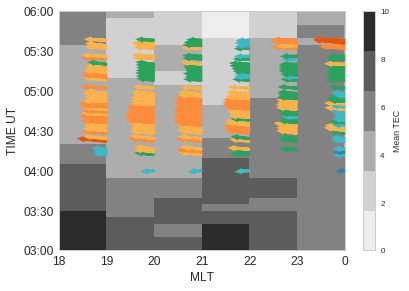

In [19]:
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Greys"))
# xticks
# set a few standard xticks
xTickList = []
currTime = timeStart
while currTime <= timeEnd:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=30)
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
trghTECMeanDF["time"] = [ date2num(x) for x in trghTECMeanDF["date"] ]
plotDF = trghTECMeanDF[ ["time", "normMlt",\
                        "med_tec"] ].pivot( "time", "normMlt" )

timeVals = plotDF.index.values
mltVals = plotDF.columns.levels[1].values

timeCntr, mlonCntr  = numpy.meshgrid( timeVals, mltVals )
# Mask the nan values! pcolormesh can't handle them well!
tecVals = numpy.ma.masked_where(\
                numpy.isnan(plotDF["med_tec"].values),\
                plotDF["med_tec"].values)
rtiPlot = ax.pcolormesh(mlonCntr.T , timeCntr.T, tecVals,\
                        cmap=seaMap, vmin=tecScale[0],vmax=tecScale[1])




colors = [ "#2c7fb8", "#41b6c4", "#2ca25f", "#feb24c", "#fd8d3c", "#e6550d" ]
seaMap = ListedColormap(sns.color_palette(colors))
# set a few standard xticks
yTickList = []
currTime = sapsTimeRange[0]
while currTime <= sapsTimeRange[1]:
    yTickList.append( currTime )
    currTime += datetime.timedelta(minutes=15)
    
    
lshellPlot = ax.scatter( x=meanVelDF["normMlt"], y=meanVelDF["time"],\
                     c=meanVelDF["velSAPS"],cmap=seaMap,\
                     vmin=velMagnScale[0],vmax=velMagnScale[1], s=1 )

colNorm = Normalize( vmin=velMagnScale[0], vmax=velMagnScale[1] )
for currMLTend, currmlatend, currMLTbgn, currmlatbgn, currVel in\
        zip( plotMLTends, plotmlatends, plotMLTbegins, plotmlatbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
#         print currMLTbgn, currMLTend
#         print currmlatbgn, currmlatend
#         ax.plot( [currMLTbgn, currMLTend], [ currmlatbgn, currmlatend ], color=currCol )   
#         ax.scatter( currMLTend, currmlatend , s=10, color=currCol, marker="<" )  
#         ax.arrow( currMLTbgn, currmlatbgn, currMLTend-currMLTbgn, currmlatend-currmlatbgn,\
#                  head_width=0.0015, head_length=0.075, fc=currCol, ec=currCol, ls='--')
        ax.arrow( currMLTbgn, currmlatbgn, currMLTend-currMLTbgn,\
                 currmlatend-currmlatbgn, head_width=0.001,\
                 head_length=0.05, fc=currCol,width=0.0001,\
                 ec=currCol, lw='3')


ax.set_ylim( [ timeStart, timeEnd ] )
ax.set_xlim( [ -6, 0 ] )
ax.set_ylabel("TIME UT", fontsize=12)
ax.set_xlabel("MLT", fontsize=12)
ax.get_yaxis().set_major_formatter(DateFormatter('%H:%M'))
ax.xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))

ax.set_yticks(xTickList)
ax.set_xticks([-6,-5,-4, -3, -2, -1, 0])
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=12)

cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("Mean TEC")

fig.savefig("../plots/lshell-tec-mlt-" +\
            sapsTime.strftime("%Y%m%d") +\
            ".pdf" ,bbox_inches='tight')